In [6]:
import numpy as np
import os
import pandas as pd 
from dateutil.parser import parse

import requests
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks

In [8]:
os.getcwd()

'/Users/sibikarthik/**SIYA PROJECT'

In [12]:
stats = pd.read_csv("/Users/sibikarthik/**SIYA PROJECT/Oil spillage dataset.csv")
stats.head()

,Spill / Vessel,Location,Dates,Min Tonnes,Max Tonnes,Owner
0,2023 Princess Empress oil spill,"Philippines, Pola, Oriental Mindoro",28 February 2023,881,881,RDC Reield Marine Services
1,2022 Keystone Pipeline oil spill,"United States, Washington County, Kansas",7 December 2022,"18,516.94","18,516.94",TC Energy
2,2022 Chesire oil truck rollover,"United States, Cheshire, Connecticut",11 February 2022,62.98,62.98,Libretti and Sons Fuel
3,2022 Callao oil spill,"Ventanilla District, Callao, Peru",15 January 2022,"1,626.39","1,861.68",Repsol
4,2021 New Orleans oil spill,"United States, St. Bernard Parish, Louisiana",27 December 2021,944.11,944.11,PBF Energy


In [22]:
stats.describe()

,Spill / Vessel,Location,Dates,Min Tonnes,Max Tonnes,Owner
count,277,277,277,266,266,133
unique,274,256,265,207,212,102
top,North Dakota pipeline spill,Nigeria,30 August 2005,unknown,unknown,Royal Dutch Shell
freq,2,4,9,18,18,9


#### Data Cleaning and Modification

In [30]:
def clean_column_names(df):
    return df.rename(columns = {'Spill / Vessel':'spill', 'Dates':'date', 'Min Tonnes':'min_tonnes', 'Max Tonnes':'max_tonnes',
                               'Location':'location'})

In [32]:
def clean_columns(df):
    return (df.assign(spill = df.spill.str.lower().astype('str'),
                    min_tonnes = df.min_tonnes.str.replace(',','').str.replace("unknown", 'nan').astype('float').fillna(0),
                    max_tonnes = df.max_tonnes.str.replace(',','').str.replace("unknown", 'nan').astype('float').fillna(0),
                    country = df.location.str.split(",").str[0],
                    region = df.location.str.split(",").str[1]))

In [34]:
def clean_date(df):
    df['date'] = df['date'].str.replace('–','-')\
                            .str.strip(' ')\
                            .str.split('-').str[0]\
                            .replace('1950\'s ', '1 January 1950')\
                            .replace('1940s ', '1 January 1940')\
                            .apply(parse)
    return df

In [36]:
def extract_transportation(df):
    ship_name_regex = fetch_ship_names()
    return (df.assign(
         transportation = np.select(
             [df.spill.str.contains(rf'(?:{ship_name_regex})'),
              df.spill.str.contains(r'(?:truck|car)'),
              df.spill.str.contains(r'(?:train|rail)'),
              df.spill.str.contains(r'(?:line)')],
             ['ship','truck','train', 'pipeline'],
             default='platform'),))

In [38]:
#Using the fact that ship names are italicized, I read the Wikipedia table containing the list of oil spills appending if the name is italicized
def fetch_ship_names():
    r = requests.get("https://en.wikipedia.org/wiki/List_of_oil_spills")
    soup = BeautifulSoup(r.text)
    
    ship_names = []
    for row in soup.find_all('table')[1].tbody.find_all('tr')[1:]:
        first_column = row.find_all('td')[0].find_all('i')
        if len(first_column) > 0:
            #print(fir.get_text())
            ship_names.append(first_column[0].get_text().lower())
    ship_names.extend(['grillo', 'luckenbach']) # additional ships that are not named but are ships nonetheless
    ship_name_regex = "|".join(ship_names)
    
    return ship_name_regex

In [40]:
df = (raw_df
    .pipe(clean_column_names)
    .pipe(clean_columns)
    .pipe(clean_date)
    .pipe(extract_transportation)
    .sort_values('date'))
df.head()

,spill,location,date,min_tonnes,max_tonnes,Owner,country,region,transportation
276,ss petriana,"Australia, Port Phillip, Victoria",1903-11-30,1300.0,1300.0,Asiatic Petroleum Company,Australia,Port Phillip,ship
275,thomas w. lawson,"United Kingdom, Isles of Scilly",1907-12-14,7400.0,7400.0,NaN,United Kingdom,Isles of Scilly,ship
274,lakeview gusher,"United States, Kern County, California",1910-03-14,1230000.0,1230000.0,NaN,United States,Kern County,platform
273,ss frank h. buck / ss president coolidge colli...,"United States, San Francisco Bay, California",1937-03-06,8870.0,8870.0,NaN,United States,San Francisco Bay,ship
270,"greenpoint, brooklyn","United States, Newtown Creek, Greenpoint, Broo...",1940-01-01,55200.0,97400.0,NaN,United States,Newtown Creek,platform


#### Exploratory Data Analysis

Text(0.5, 0.98, 'Estimated Cumulative Tonnes of Oil Spills')

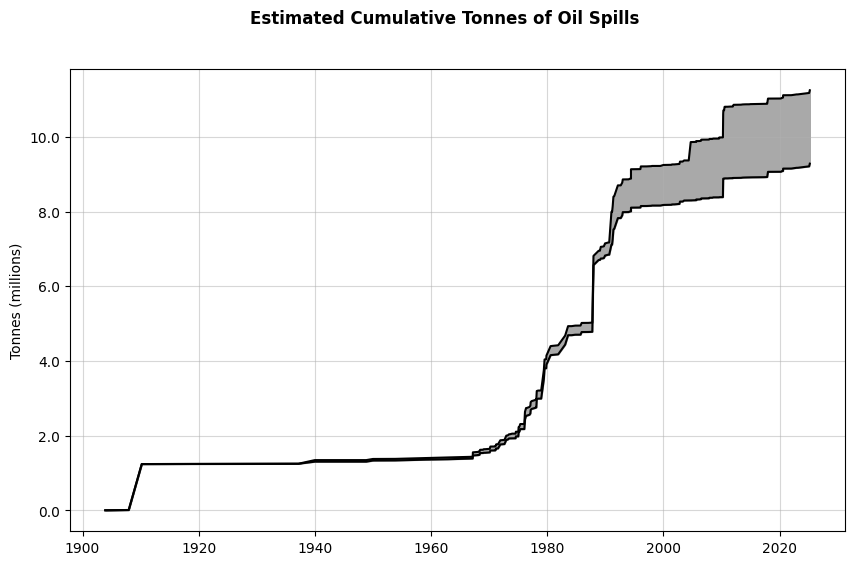

In [48]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df['date'], df['min_tonnes'].cumsum(), color='black')
ax.plot(df['date'], df['max_tonnes'].cumsum(), color='black')
ax.fill_between(x=df['date'], y1=df['min_tonnes'].cumsum(), y2=df['max_tonnes'].cumsum(), color='darkgrey')
ax.grid('-', alpha=0.5)
ax.set_ylabel("Tonnes (millions)")
ax.get_yaxis().set_major_formatter(mticks.FuncFormatter(lambda x, p: format(x/1000000, ',')))

plt.suptitle("Estimated Cumulative Tonnes of Oil Spills", weight='bold', size=12)

In [50]:
df.transportation.value_counts()

transportation
ship        137
platform    106
pipeline     29
truck         3
train         2
Name: count, dtype: int64

Text(0.5, 0.98, 'Estimated Cumulative Tonnes of Oil Spills, by Incident Type')

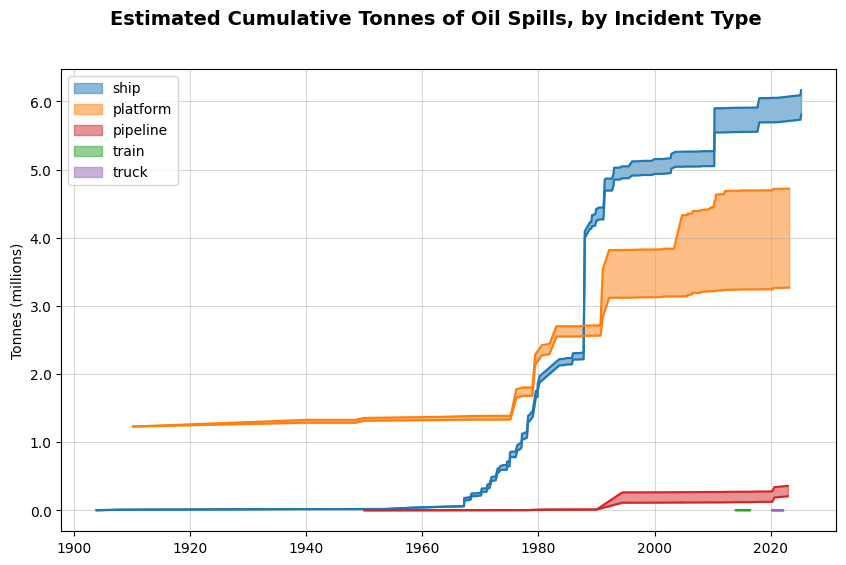

In [52]:
fig, ax = plt.subplots(figsize=(10,6))
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green', 'tab:purple']

for i, method in enumerate(df.transportation.unique()):
    dft = df.query("transportation == @method").sort_values('date').copy()
    
    ax.plot(dft['date'], dft['min_tonnes'].cumsum(), colors[i])
    ax.plot(dft['date'], dft['max_tonnes'].cumsum(), colors[i])
    ax.fill_between(x=dft['date'], y1=dft['min_tonnes'].cumsum(), y2=dft['max_tonnes'].cumsum(), color=colors[i], alpha=0.5, label=method)

    ax.grid('-', alpha=0.5)
ax.set_ylabel("Tonnes (millions)")
ax.get_yaxis().set_major_formatter(mticks.FuncFormatter(lambda x, p: format(x/1000000, ',')))
ax.legend()

plt.suptitle("Estimated Cumulative Tonnes of Oil Spills, by Incident Type", weight='bold', size=14)

) missing from font(s) DejaVu Sans..9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


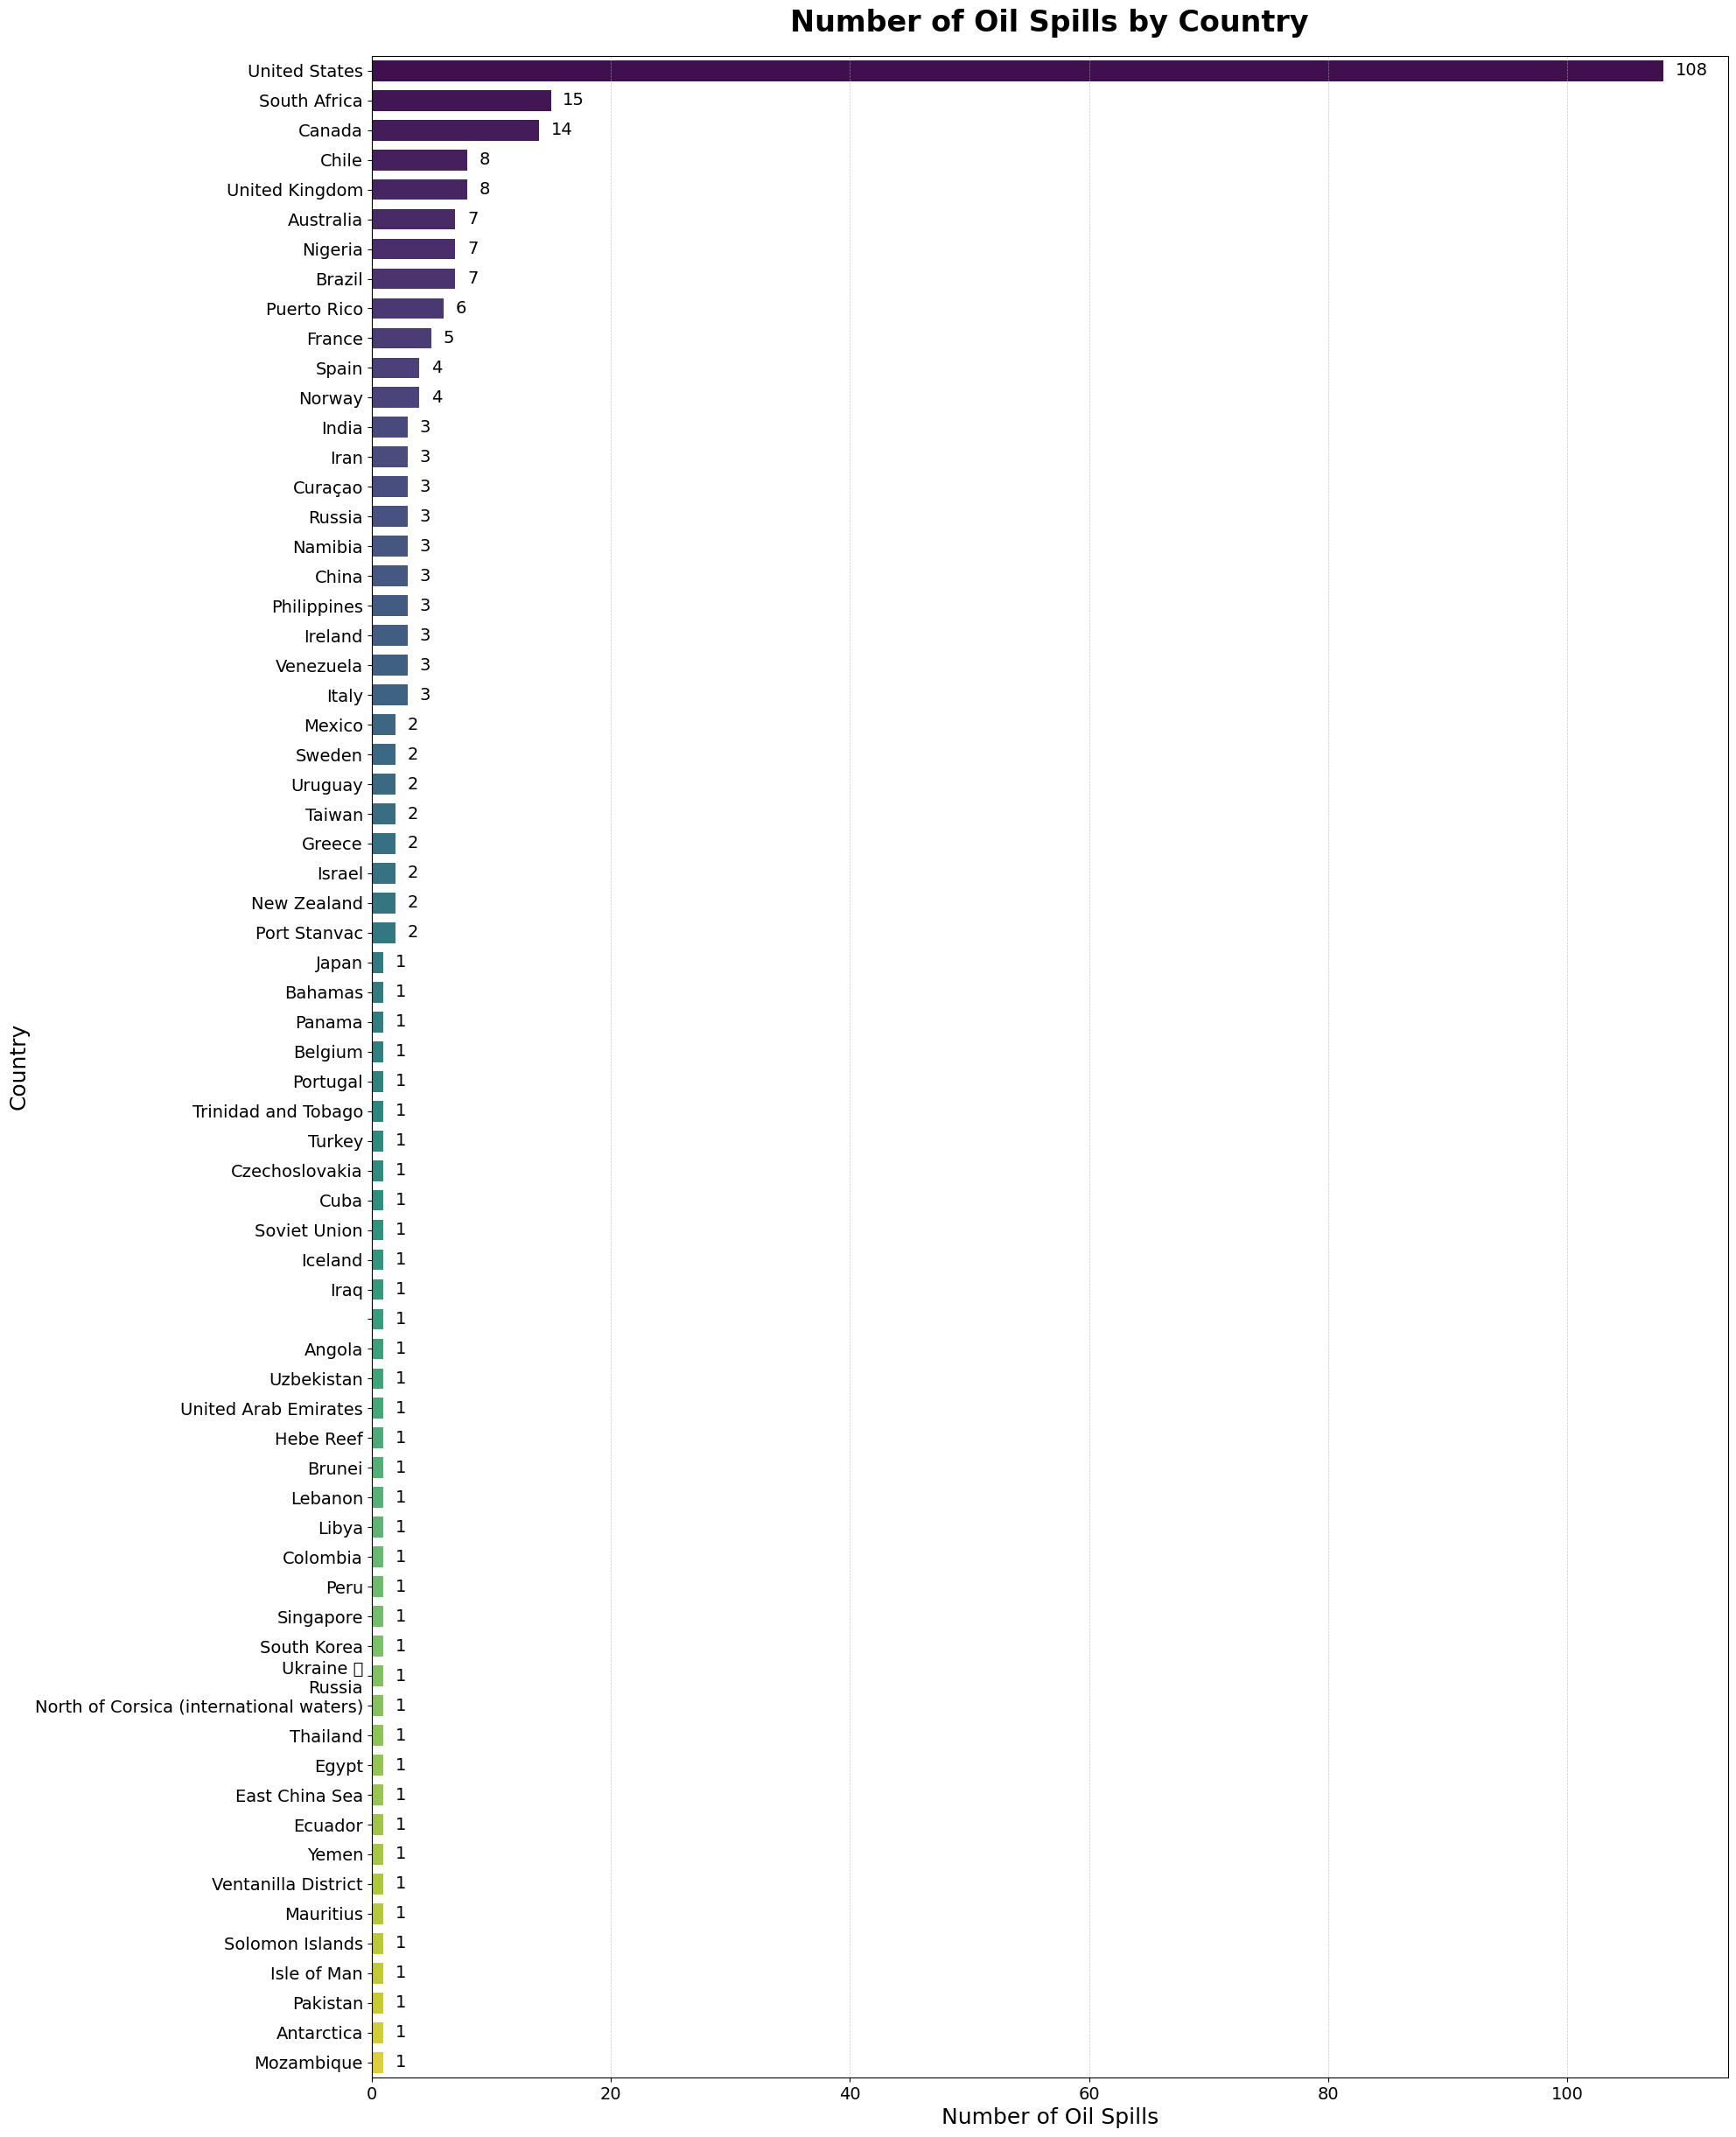

In [70]:
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'num_spills']

# Sort by spill counts for clarity
country_counts = country_counts.sort_values('num_spills', ascending=False)

# Enhanced bar plot
plt.figure(figsize=(20, 30))  # Increased figure size
ax = sns.barplot(y='country', x='num_spills', data=country_counts, palette='viridis', width=0.7)

# Improved labels and title
plt.title('Number of Oil Spills by Country', weight='bold', size=24, pad=20)
plt.xlabel('Number of Oil Spills', size=18)
plt.ylabel('Country', size=18)

# Add spill counts to bars with better positioning
for index, value in enumerate(country_counts['num_spills']):
    ax.text(value + 1, index, str(value), color='black', ha='left', va='center', fontsize=14)

# Improve visibility
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()